# This notebook solves the Huggett Model (1993) using Dolo.

This is a heterogeneous-agent model where each period agents are hit with idiosyncratic income shocks $y_t$ that follow an $AR1$ process. There are incomplete markets and agents only have access to a risk-free asset $s_t$ that pays $(1+r)s_t$ next period, where $r$ is the interest rate.

The value function for an agent with current assets $s$ and current income $y$ is: $v(y,s)=\max_{c,s'} u(c)+\beta \mathbf{E}v(y',s')$ where the expectation is taken over the value of the income shock.

The agent's budget constraint is: $c+s'=(1+r)s+y$ where s' is his asset choice next period. The agent will also be subject to a borrowing constraint: $s'\geq \bar{s}$.

Here, we define the control in the model as $a=s'-s$, i.e. $a$ is the change in assets.


In [1]:
# First import the packages
Pkg.dir("Dolo")
import Dolo
using AxisArrays
using PyPlot

. To use SymEngine run the following code: `Pkg.add("SymEngine")`


In [2]:
# get the model file
filename=("huggett_1993.yaml")

"huggett_1993.yaml"

In [3]:
# Convert the file into Dolo model
model=Dolo.yaml_import(filename)

name,Huggett 1993
filename,huggett_1993.yaml
Type,Equation
value,\[V_{t} = \frac{\left(c_{t}\right)^{\left(1-\sigma\right)}}{\left(1-\sigma\right)}+\beta V_{t+1}\]
expectation,\[m_{t} = \frac{\beta}{\left(c_{t+1}\right)^{\sigma}} 1+r\]
felicity,\[u_{t} = \frac{\left(c_{t}\right)^{\left(1-\sigma\right)}}{\left(1-\sigma\right)}\]
transition,\[s_{t} = a_{t-1}+s_{t-1}\]
arbitrage,\[\left(1-\beta \left(\frac{c_{t}}{c_{t+1}}\right)^{\sigma} 1+r\right)\]


Model


Create a function to loop over guesses of the interest rate until the asset market clears.

In [8]:
function solve_r(r_val, dr_guess; N=500, T=500)
    mc_ar=model.exogenous
    sol=Dolo.time_iteration(model,dr_guess; verbose=false)
    dr=sol.dr
    sim_armc = Dolo.simulate(model,dr;N=500,T=500)
    r=model.calibration.flat[:r]
    assets_end=zeros(N)
    for ii=1:N # number of simulations
      c=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T]+sim_armc[Axis{:N}(ii), Axis{:V}(:s)][T]*r-sim_armc[Axis{:N}(ii), Axis{:V}(:a)][T]
      assets_end[ii]=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T]-c[end]
    end
    
    model_resid=mean(assets_end)
    return model_resid, dr
end

solve_r (generic function with 3 methods)

solve_r(Any, Any) in module Main at In[5]:2 overwritten at In[8]:2.


In [9]:
function asset_clear(model)
    r_grid=linspace(0.0001, 0.06,80)
    resid_vec=similar(r_grid)
    it=1
    tol=0.0001
    dr_guess=Dolo.ConstantDecisionRule(model.calibration[:controls])
    max_it=length(r_grid)
        while it<max_it
            r_val=r_grid[it]
            model_resid, dr=solve_r(r_val, dr_guess) 
            resid_vec[it]=model_resid

            if abs(model_resid)<tol
                println(model_resid)
                println("Market Clearing with r ", r_val)
                break
            else
                println("With r ", r_val, " the level of assets is ", model_resid)
                it=it+1
            end
        end
    
end



asset_clear (generic function with 1 method)

asset_clear(Any) in module Main at In[6]:2 overwritten at In[9]:2.


In [ ]:
asset_clear(model)

With r 0.0001 the level of assets is 0.059601682387805825
With r 0.0008582278481012658 the level of assets is -0.018528282176709338
With r 0.0016164556962025315 the level of assets is -0.0411573238745795
With r 0.0023746835443037976 the level of assets is 0.027181264528867558
With r 0.0031329113924050632 the level of assets is 0.021429815330591052
With r 0.0038911392405063293 the level of assets is 0.05416760401452169
With r 0.004649367088607595 the level of assets is 0.056296824866205554
With r 0.005407594936708861 the level of assets is 0.013105474458677173
With r 0.006165822784810126 the level of assets is -0.016012112198341467
With r 0.006924050632911393 the level of assets is 0.031409694531183405
With r 0.007682278481012658 the level of assets is -0.040280956061266464
With r 0.008440506329113924 the level of assets is -0.026187710722748853
With r 0.00919873417721519 the level of assets is 0.05246990780411622
With r 0.009956962025316455 the level of assets is -0.021473550332505257


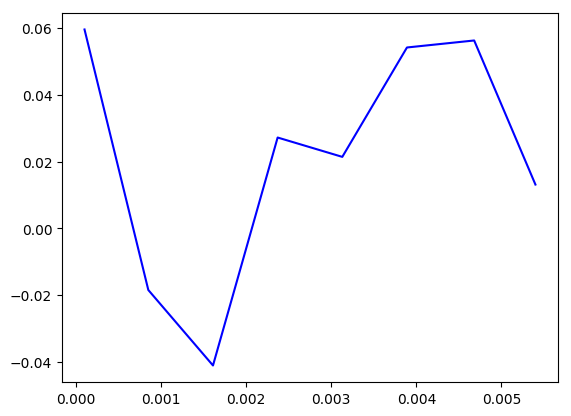

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x000000001E797240>

In [1]:
import PyPlot
plt=PyPlot
rvec=[0.0001, 0.00085, 0.00161, 0.00237, 0.00313,0.00389, 0.00468, 0.00540]
asset_demand=[0.0596, -0.01852, -0.04115, 0.0272, 0.0214, 0.0542, 0.0563, 0.0131]


plt.plot(rvec, asset_demand, color="blue")

In [ ]:
@time sol=Dolo.time_iteration(model,verbose=true, maxit=1000)
dr=sol.dr
@time res = Dolo.time_iteration(model, dr; maxit=200)

Dolo tabulate gives us the decision rules.

In [ ]:
drtab = Dolo.tabulate(model, dr, :s) 

Now we plot the consumption policy function. We see that it is concave because of the precautionary savings motive noting as well that there is more curvature closer to the borrowing constraint.

In [ ]:
# Plot the consumption policy function
import PyPlot
plt=PyPlot
r=model.calibration.flat[:r]
print(r)
c=exp(drtab[Axis{:V}(:lny)])+drtab[:s]*r-drtab[Axis{:V}(:a)]

plt.plot(drtab[Axis{:V}(:s)],c, color="blue")
plt.xlabel("Savings")
plt.ylabel("Consumption")
plt.title("Consumption Policy Function")

### Simulations

Here we run simulations for N agents and look at the asset distribution.

In [ ]:
# Simulations
import PyPlot
plt=PyPlot


mc_ar=model.exogenous

sim_armc = Dolo.simulate(model,dr;N=1000,T=200)


T=200

In [ ]:
N=1000
n=200 # number of periods to plot
hor=linspace(1,n,n)
function plot_simulations(N::Int64,T::Int64,n::Int64,sim_armc)
    assets_end=zeros(N)
    for ii=1:N # number of simulations
          
        c=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T-n+1:T]+sim_armc[Axis{:N}(ii), Axis{:V}(:s)][T-n+1:T]*r-sim_armc[Axis{:N}(ii), Axis{:V}(:a)][T-n+1:T]
        assets_end[ii]=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T]-c[end]

        #assets_end[ii]=exp(sim_armc[Axis{:N}(ii), Axis{:V}(:lny)])[T]-c[end]
    
    end

    return assets_end
end




In [ ]:
assets_end=plot_simulations(N,T,n,sim_armc);

We see that the average asset holdings is very close to zero so we have market clearing.

In [ ]:
using Plots
histogram(assets_end,nbins=80,xlims=(-2.0,4.0), ylims=(0.0,120.0), label="", xlabel="Assets", ylabel="Frequency", title="Assets Distribution")


In [ ]:
mean(assets_end)